In [ ]:
from __future__ import annotations



from pathlib import Path

from typing import Tuple



import numpy as np

import pandas as pd

from sklearn.preprocessing import LabelEncoder, MinMaxScaler



DATA_CANDIDATES = (

    Path("data/titanic"),

    Path("/kaggle/input/titanic-dataset"),

    Path("/data/titanic"),

)

FEATURE_COLUMNS = ["Pclass", "Age", "SibSp", "Parch", "Fare", "Sex"]

NUMERIC_FEATURES = ["Pclass", "Age", "SibSp", "Parch", "Fare"]





def locate_dataset(

    train_filename: str = "train.csv",

    test_filename: str = "test.csv",

) -> Tuple[Path, Path]:

    """Return filesystem paths for the Titanic train/test CSV files."""

    for base_path in DATA_CANDIDATES:

        train_path = base_path / train_filename

        test_path = base_path / test_filename

        if train_path.exists() and test_path.exists():

            return train_path, test_path

    raise FileNotFoundError(

        "Could not locate the Titanic dataset. Update DATA_CANDIDATES with the correct folder."

    )





def load_datasets() -> Tuple[pd.DataFrame, pd.DataFrame]:

    """Load train and test DataFrames using the first available dataset location."""

    train_path, test_path = locate_dataset()

    return pd.read_csv(train_path), pd.read_csv(test_path)





def preprocess_features(

    df: pd.DataFrame,

    scaler: MinMaxScaler,

    label_encoder: LabelEncoder,

    *,

    fit_transform: bool,

) -> pd.DataFrame:

    """Normalize numeric features and encode categoricals into the [-1, 1] range."""

    processed = df[FEATURE_COLUMNS].copy()

    processed["Age"] = processed["Age"].fillna(processed["Age"].median())

    processed["Fare"] = processed["Fare"].fillna(processed["Fare"].median())

    processed["SibSp"] = processed["SibSp"].fillna(0)

    processed["Parch"] = processed["Parch"].fillna(0)

    processed["Pclass"] = processed["Pclass"].fillna(processed["Pclass"].mode().iloc[0])

    processed["Sex"] = processed["Sex"].fillna("missing")

    if fit_transform:

        processed[NUMERIC_FEATURES] = scaler.fit_transform(processed[NUMERIC_FEATURES])

        sex_encoded = label_encoder.fit_transform(processed["Sex"])

    else:

        processed[NUMERIC_FEATURES] = scaler.transform(processed[NUMERIC_FEATURES])

        sex_encoded = label_encoder.transform(processed["Sex"])

    processed["Sex"] = sex_encoded * 2 - 1

    return processed





def prepare_training_arrays(

    train_df: pd.DataFrame,

) -> Tuple[np.ndarray, np.ndarray, MinMaxScaler, LabelEncoder]:

    """Create numpy arrays plus fitted preprocessing objects for training."""

    scaler = MinMaxScaler(feature_range=(-1, 1))

    label_encoder = LabelEncoder()

    features = preprocess_features(

        train_df,

        scaler,

        label_encoder,

        fit_transform=True,

    )

    labels = train_df["Survived"].astype(np.float32)

    return (

        features.to_numpy(dtype=np.float32),

        labels.to_numpy(dtype=np.float32),

        scaler,

        label_encoder,

    )





def prepare_test_array(

    test_df: pd.DataFrame,

    scaler: MinMaxScaler,

    label_encoder: LabelEncoder,

) -> np.ndarray:

    """Apply previously fitted preprocessing objects to the Kaggle test set."""

    processed = preprocess_features(

        test_df,

        scaler,

        label_encoder,

        fit_transform=False,

    )

    return processed.to_numpy(dtype=np.float32)


Epoch 1/120
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.5643 - loss: 0.6841 - val_accuracy: 0.7765 - val_loss: 0.5678 - learning_rate: 0.0010
Epoch 2/120
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8002 - loss: 0.5250 - val_accuracy: 0.7877 - val_loss: 0.4748 - learning_rate: 0.0010
Epoch 3/120
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8142 - loss: 0.4425 - val_accuracy: 0.8101 - val_loss: 0.4627 - learning_rate: 0.0010
Epoch 4/120
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8239 - loss: 0.4171 - val_accuracy: 0.7821 - val_loss: 0.4589 - learning_rate: 0.0010
Epoch 5/120
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8086 - loss: 0.4246 - val_accuracy: 0.8101 - val_loss: 0.4521 - learning_rate: 0.0010
Epoch 6/120
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8146 - loss: 0.4193 - val_accuracy: 0.7989 - val_loss: 0.4505 - learning_rate: 0.0010
Epoch 7/120
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8195 - loss: 0.4208 - val_ac

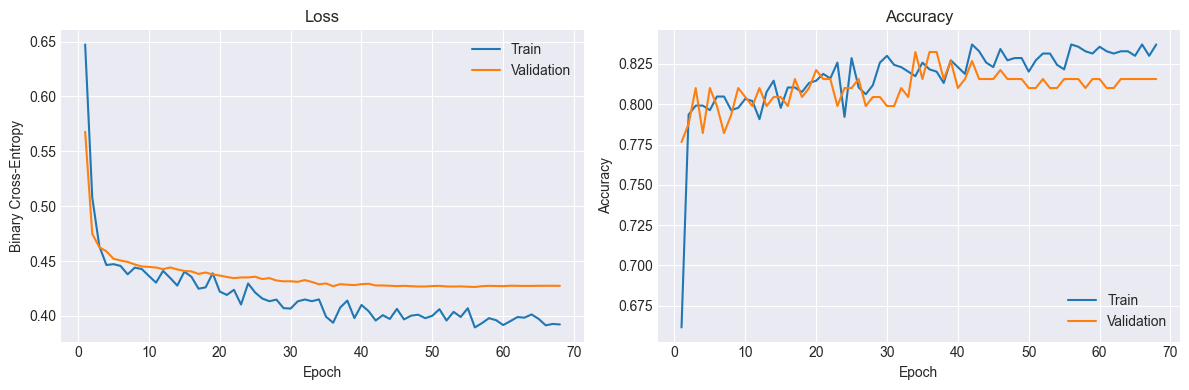

Validation accuracy: 0.816 (best epoch: 34)
Submission saved to C:\projects\ML Projects\ML-Projects\data\titanic\submission.csv


{'val_loss': 0.42640015482902527,
 'val_accuracy': 0.8156424760818481,
 'best_epoch': 34.0}

In [ ]:
from pathlib import Path

from typing import Dict



import matplotlib.pyplot as plt

import numpy as np

import pandas as pd

import tensorflow as tf

from sklearn.model_selection import train_test_split



plt.style.use("seaborn-v0_8-darkgrid")

tf.keras.utils.set_random_seed(42)

tf.get_logger().setLevel("ERROR")





def create_model(input_dim: int) -> tf.keras.Model:

    """Build a compact feed-forward network for binary classification."""

    tf.keras.backend.clear_session()

    model = tf.keras.Sequential(

        [

            tf.keras.layers.Input(shape=(input_dim,)),

            tf.keras.layers.Dense(128, activation="relu"),

            tf.keras.layers.Dropout(0.25),

            tf.keras.layers.Dense(64, activation="relu"),

            tf.keras.layers.Dropout(0.25),

            tf.keras.layers.Dense(32, activation="relu"),

            tf.keras.layers.Dense(1, activation="sigmoid"),

        ]

    )

    model.compile(

        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),

        loss="binary_crossentropy",

        metrics=["accuracy"],

    )

    return model





def plot_training_curves(history: tf.keras.callbacks.History) -> None:

    """Render loss and accuracy curves for quick visual inspection."""

    epochs = range(1, len(history.history["loss"]) + 1)

    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)

    plt.plot(epochs, history.history["loss"], label="Train")

    plt.plot(epochs, history.history["val_loss"], label="Validation")

    plt.title("Loss")

    plt.xlabel("Epoch")

    plt.ylabel("Binary Cross-Entropy")

    plt.legend()

    plt.subplot(1, 2, 2)

    plt.plot(epochs, history.history["accuracy"], label="Train")

    plt.plot(epochs, history.history["val_accuracy"], label="Validation")

    plt.title("Accuracy")

    plt.xlabel("Epoch")

    plt.ylabel("Accuracy")

    plt.legend()

    plt.tight_layout()

    plt.show()





def predict_test_set(

    model: tf.keras.Model,

    test_df: pd.DataFrame,

    scaler: MinMaxScaler,

    label_encoder: LabelEncoder,

) -> pd.DataFrame:

    """Generate a Kaggle-ready submission DataFrame."""

    test_features = prepare_test_array(test_df, scaler, label_encoder)

    probabilities = model.predict(test_features, verbose=0).ravel()

    predictions = (probabilities >= 0.5).astype(int)

    return pd.DataFrame(

        {

            "PassengerId": test_df["PassengerId"].astype(int),

            "Survived": predictions,

        }

    )





def run_training_pipeline(

    test_size: float = 0.2,

    seed: int = 42,

    epochs: int = 120,

    batch_size: int = 32,

) -> Dict[str, float]:

    """Train the classifier, evaluate it, and export predictions."""

    train_df, test_df = load_datasets()

    X, y, scaler, label_encoder = prepare_training_arrays(train_df)

    X_train, X_val, y_train, y_val = train_test_split(

        X,

        y,

        test_size=test_size,

        stratify=y,

        random_state=seed,

    )

    model = create_model(X_train.shape[1])

    callbacks = [

        tf.keras.callbacks.ReduceLROnPlateau(

            monitor="val_loss", factor=0.5, patience=5, min_lr=1e-5

        ),

        tf.keras.callbacks.EarlyStopping(

            monitor="val_loss", patience=12, restore_best_weights=True

        ),

    ]

    history = model.fit(

        X_train,

        y_train,

        validation_data=(X_val, y_val),

        epochs=epochs,

        batch_size=batch_size,

        callbacks=callbacks,

        verbose=1,

    )

    plot_training_curves(history)

    val_loss, val_accuracy = model.evaluate(X_val, y_val, verbose=0)

    best_epoch = int(np.argmax(history.history["val_accuracy"])) + 1

    print(f"Validation accuracy: {val_accuracy:.3f} (best epoch: {best_epoch})")

    submission_df = predict_test_set(model, test_df, scaler, label_encoder)

    submission_path = Path("data/titanic/submission.csv")

    submission_df.to_csv(submission_path, index=False)

    print(f"Submission saved to {submission_path.resolve()}")

    return {

        "val_loss": float(val_loss),

        "val_accuracy": float(val_accuracy),

        "best_epoch": float(best_epoch),

    }





metrics = run_training_pipeline()

metrics
